In [1]:
import control as ct
import numpy as np
import sympy
from sympy import symbols, nroots, I, Abs, arg
from sympy.functions.elementary.exponential import exp
from sympy.functions.elementary.trigonometric import sin
from sympy.functions.elementary.complexes import re, im
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
## Initialize all functions

# Set up open loop transfer function from the flame transfer function
# and the accoustic transfer function.

# # Load coefficients
# data = np.load("tf_coefficients.npz")
# poles = data["poles"]
# residues = data["residues"]
# d = data["d"].item()  # scalar
# e = data["e"].item()  # scalar

# print(poles)

# # Recreate the callable H_func
# def H_func(f_input):
#     s = I * 2 * np.pi * np.array(f_input, ndmin=1)
#     H_out = np.zeros_like(s, dtype=complex)
#     for r, p in zip(residues, poles):
#         H_out += r / (s - p)
#     H_out += d + e * s
#     if np.isscalar(f_input):
#         return H_out[0]
#     return H_out


def func2(x, A, B, C, D):
    return A + (B / (1 + exp(-C*(x-D))))

def FTF_time_delay(s, K, x_i):
#     s = 1j * 2 * np.pi * np.array(f_input, ndmin=1)
#     H_out = np.zeros_like(s, dtype=complex)
#     for r, p in zip(residues, poles):
#         H_out += r / (s - p)
#     H_out += d + e * s
#     if np.isscalar(f_input):
#         return H_out[0]
#     return H_out
#     coeffs = []
#     H = 0
#     for r, p in coeffs[0:-3]:
#         H += r/(s+p)
#     for
    return 0.8/(1/700+s)*exp(-s*abs(x_i)/K)  # ((s+7)/(s**2+6*s+8)*0.5*exp(-s*abs(x_i)/K)) # / (1+(s)/(s**2+6*s+8)*0.5*exp(-s*abs(x_i)/K))
#     return  (1+s+s**2+s**3+s**4+ 4.29317541*10**9*s**5 -7.80925127*10**7*s**6+  3.98755874*10**5*s**7-\
#             3.83373369*10**2*s**8)/(1+s+s**2 + 1.13340178*10**0*s**3+  7.34837025*10**4*s**4+\
#             2.99563498*10**4*s**5 - 4.01492165*10**6*s**61.18602109 *10**5*s**7 -\
#             1.14238835*10**3*s**7+  3.61014623*10**0*s**8) * func2((im(s)-117.5)%57.5, 1.49, -3.07, 0.142, 147.43)  *  exp(-abs(x_i)/K*s)

def ATF_single_mode(s):
    return 1

def L(s, params):
    return -FTF_time_delay(s, params[0], params[1])*ATF_single_mode(s)




# Define the stability margin  and sensitivity function
def stability_margin(params):
    return [Abs(sympy.N(Abs(1+L(I*omega, params)))) for omega in omegas]

def sensitivity_transfer_values(omega, params):
    L_value = L(I*omega, params)
    mu = Abs(sympy.N(Abs(1+L_value)))
    return 1/mu, L_value




# Determine critical frequencies and corresponding maximum sensitivity
def critical_frequency(params, omegas_crit, freq_diff=0.1):
    print(omegas_crit)
    # Determine all the sensitivities for the system
    sensitivities = dict()
    for omega in omegas:
        sensitivities[omega] = sensitivity_transfer_values(omega, params)[0]
        
    # Find the corresponsing critical frequency to the max sensitivity
    max_sensitivity = max(sensitivities.values())
    for omega in omegas:
        if sensitivities.get(omega) == max_sensitivity:
            for w_crit in omegas_crit:
                if abs(w_crit - omega) < freq_diff:
                    omegas_crit.remove(w_crit)
            omegas_crit.append(omega)
            
    return omegas_crit



# Determine frequency response of our flame transfer function
def frequency_response(L, params, omega_min=-2, omega_max=1, n=300):
    omegas = np.logspace(omega_min, omega_max, n)
    response = [L(I*omega, params) for omega in omegas]
    return [Abs(sympy.N(r)) for r in response], [arg(sympy.N(r)) for r in response], omegas



# Define the objective to minimize over all critical frequencies
def objective_for_optimizer(params, omegas_crit, FTF_func, ATF_func,
                            instability_penalty=1e4, penalty_margin=-1.0):
    K, x_i = params
    # optional: limit K to positive if physics requires; here we allow any real but can penalize invalid ranges
    if K <= 0 or x_i >= 0:
        # hard penalty for non-physical K (tunable) and x_i
        return 1e6 + 1e3 * max(abs(K), abs(x_i))
    
    J = 0
    for omega_crit in omegas_crit:
        S_vals, L_vals = sensitivity_transfer_values(omega_crit, params)
        J = max(J, float(np.max(S_vals)))

    # penalty: if for any tested freq Re(L) < penalty_margin (paper uses -1),
    # they add +1e4 to the cost. Ensures no loop around -1.
    if re(L_vals) < penalty_margin:
        J +=  instability_penalty # instability_penalty

    return J

def J(params):
    return objective_for_optimizer(params, omegas_crit, FTF_time_delay, ATF_single_mode)

def optimize_params(params):
    x0 = np.array([1.2, -2.0])
    res = minimize(J, x0, method='Nelder-Mead', options={'maxiter': 200, 'xatol':1e-3, 'fatol':1e-3, 'disp': True})
    return res.x

def optimize_system(Nit, x0, omegas_crit):
    all_params = [x0]
    for i in range(Nit):
        x0 = optimize_params(x0)
        omegas_crit = critical_frequency(x0, omegas_crit)
        all_params.append(x0)
    return all_params

In [3]:
## Initialize parameters

# Get all frequencies to investigate the system for
omega_min = -2    # logspace
omega_max = 2     # logspace
n         = 1000   # number of frequency evaluations
omegas    = np.logspace(omega_min, omega_max, n);

# Initial parameters
params_initial = [1.2, -2.0]    # initial parameters for the system

# Critical frequency
omegas_crit = critical_frequency(params_initial, list(), 0.1);

[]


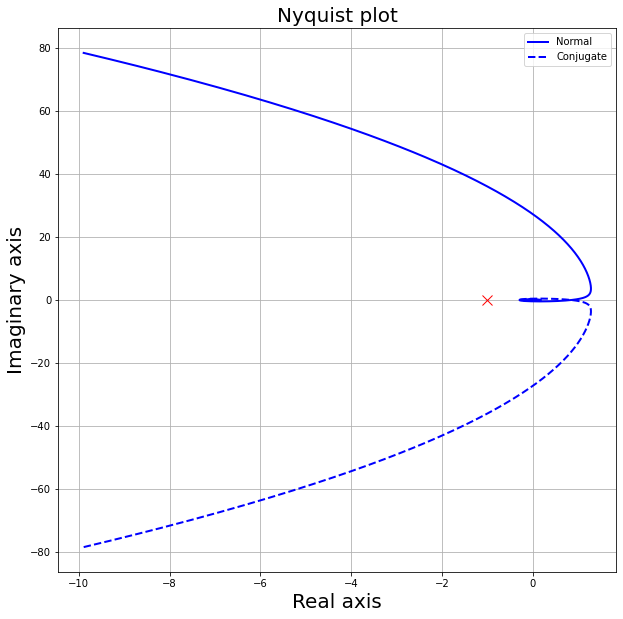

In [4]:
## Nyquist plot
plt.figure(figsize=(10,10))

response = [L(I*omega, params_initial) for omega in omegas]
response_real = [re(x) for x in response]
response_im = [im(x) for x in response]
response_im_conj = [-im(x) for x in response]

# print(response_real)
plt.plot(response_real, response_im, linewidth=2,color='b')
plt.plot(response_real, response_im_conj, linewidth=2, color='b',linestyle='--')
plt.plot(-1,0, 'r', marker='x',markersize=10)
plt.grid()
plt.xlabel('Real axis',size=20)
plt.ylabel('Imaginary axis',size=20)
plt.title('Nyquist plot',size=20)
# plt.show()
plt.legend(['Normal', 'Conjugate'])


plt.savefig('Nyquist plot example case2.png')

In [5]:
sensitivities = dict()
for omega in omegas:
    sensitivities[omega] = sensitivity_transfer_values(omega, params_initial)[0]

max_sens = max(sensitivities.values())
omega_crit = list()
for omega in omegas:
    if sensitivities.get(omega) == max_sens:
        omega_crit.append(omega)
print(omega_crit)

[2.7443433032283653]


1.40360941234013

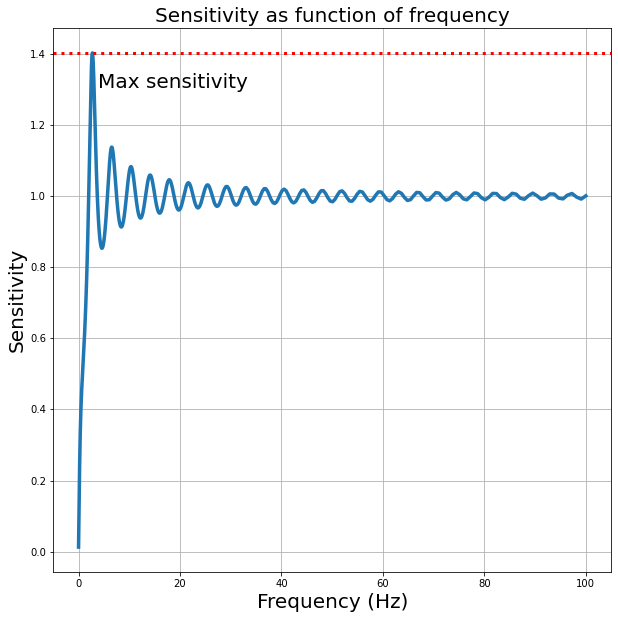

In [6]:
plt.figure(figsize=(10,10))
plt.plot(sensitivities.keys(), sensitivities.values(),linewidth=3.5)
# plt.plot(sensitivities.keys(), [max_sens for i in range(len(sensitivities.keys()))])
plt.axhline(y=max_sens, color='r', linestyle='dotted',linewidth=3)
plt.title('Sensitivity as function of frequency',size=20)
plt.xlabel('Frequency (Hz)',size=20)
plt.ylabel('Sensitivity',size=20)
plt.grid()
plt.text(omega_crit[0]+1, max_sens-0.1,'Max sensitivity',size=20)

max(sensitivities.values())

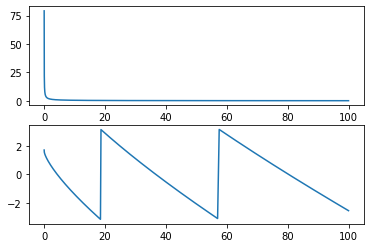

In [7]:
mag, phase, omega = frequency_response(L, params_initial, n=n)

# Plot the absolute value and phase of the repsonse of th ftf
fig, ax = plt.subplots(2)
ax[0].plot(omegas, mag)
ax[1].plot(omegas, phase)

In [8]:
print(Abs(sympy.N(mag[0])))

79.1959594928933


In [9]:
all_params = optimize_system(5, params_initial, omegas_crit)

Optimization terminated successfully.
         Current function value: 0.774288
         Iterations: 43
         Function evaluations: 77
[2.7443433032283653]
Optimization terminated successfully.
         Current function value: 0.908290
         Iterations: 41
         Function evaluations: 74
[2.7443433032283653, 7.923168624866253]
Optimization terminated successfully.
         Current function value: 1.068523
         Iterations: 37
         Function evaluations: 66
[2.7443433032283653, 7.923168624866253, 4.556786265841064]
Optimization terminated successfully.
         Current function value: 0.908290
         Iterations: 46
         Function evaluations: 81
[2.7443433032283653, 7.923168624866253, 4.556786265841064, 3.552634676578139]
Optimization terminated successfully.
         Current function value: 0.965907
         Iterations: 36
         Function evaluations: 68
[2.7443433032283653, 7.923168624866253, 4.556786265841064, 3.552634676578139, 22.664980792736927]


In [10]:
#all_params = [[1.2, -2.0],[ 2.26075600e+00, -6.59345985e-10]]#,[ 0.01396784, -3.82389869],[ 2.26075600e+00, -6.59345985e-10],\
# [ 0.01396784, -3.82389869],[ 2.26075600e+00, -6.59345985e-10],[ 0.01396784, -3.82389869],[ 2.26075600e+00, -6.59345985e-10],\
# [ 0.01396784, -3.82389869],[ 2.26075600e+00, -6.59345985e-10],[ 0.01396784, -3.82389869]]

plt.figure(figsize=(10,10))
all_sensitivities = list()
for param in all_params:
    sensitivities = dict()
    for omega in omegas:
        sensitivities[omega] = sensitivity_transfer_values(omega, param)[0]
    all_sensitivities.append(sensitivities)
    print(max(sensitivities.values()))
    

1.40360941234013
1.11016837777262
1.20701731791272
1.28368262624057
1.03565448916580
1.06397510037201


<Figure size 720x720 with 0 Axes>

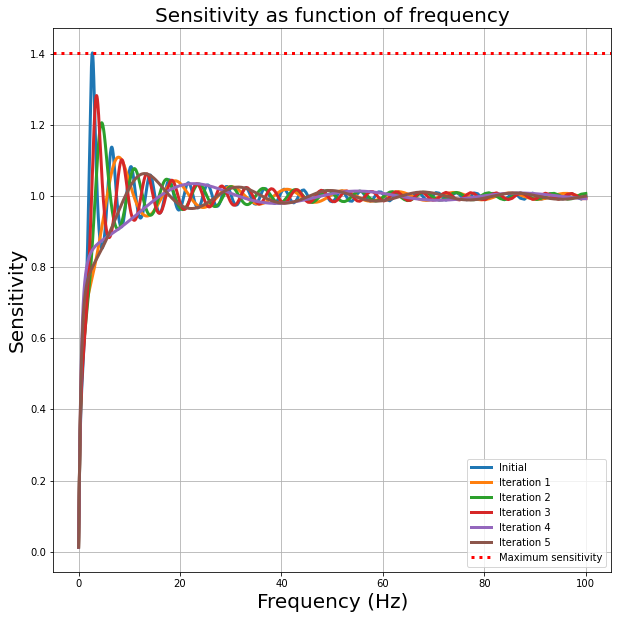

In [15]:
plt.figure(figsize=(10,10))
j=0.1
for i in all_sensitivities:
    plt.plot(i.keys(), i.values(),linewidth=3)
    j+=0.14
plt.axhline(y=max_sens, color='r', linestyle='dotted',linewidth=3)
plt.title('Sensitivity as function of frequency',size=20)
plt.xlabel('Frequency (Hz)',size=20)
plt.ylabel('Sensitivity',size=20)
plt.grid()
# plt.text(omega_crit[0]+1, max_sens-0.1,'Max sensitivity',size=20)
# plt.xlim([0,2])
legend_list = ['Iteration ' + str(i+1) for i in range(5)]
plt.legend(['Initial'] + legend_list + ['Maximum sensitivity'])

plt.savefig('Optimizing sensitivity6.png')

In [12]:
## Nyquist plot
plt.figure(figsize=(10,10))

response = [L(I*omega, all_params[-1]) for omega in omegas]
response_real = [re(x) for x in response]
response_im = [im(x) for x in response]
response_im_conj = [-im(x) for x in response]

<Figure size 720x720 with 0 Axes>

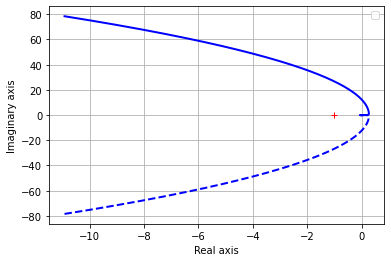

In [13]:
# print(response_real)
plt.plot(response_real, response_im, linewidth=2, color='b', linestyle='-')
plt.plot(response_real, response_im_conj, linewidth=2, color='b', linestyle='--')
plt.plot(-1,0, color='r', marker='+')
plt.grid()
plt.xlabel('Real axis')
plt.ylabel('Imaginary axis')
plt.legend([])
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.savefig('Optimize nyquist plot.png')
plt.show()

In [14]:
all_params[-1]

array([ 1.69226039, -0.58641558])